In [12]:
import re
import csv

import tellurium as te
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix_man_explicit.ant'
fn_sbml = fn_ant.replace('.ant','.sbml')

# Compare results

In [13]:
r_out = pd.read_csv('../tmp/r_out_full.csv').drop(columns=['Unnamed: 0'])
q_cols = {'1':'QVen', '2':'QArt', '3':'QFat', '4':'QPoor', '5':'QRich', '6':'QLiver',
                      '7':'QSkin_u', '8':'QSkin_e', '9':'QSkin_sc_u', '10':'QSkin_sc_e',
                      '11':'QGut', '12':'QExcret', '13':'QMetab'}
r_out.rename(columns=q_cols, inplace=True)
long_r = pd.melt(r_out[['time']+list(q_cols.values())], id_vars=['time'], value_vars=q_cols.values(), 
                 var_name='quantity', value_name='value')
long_r['src'] = 'R'

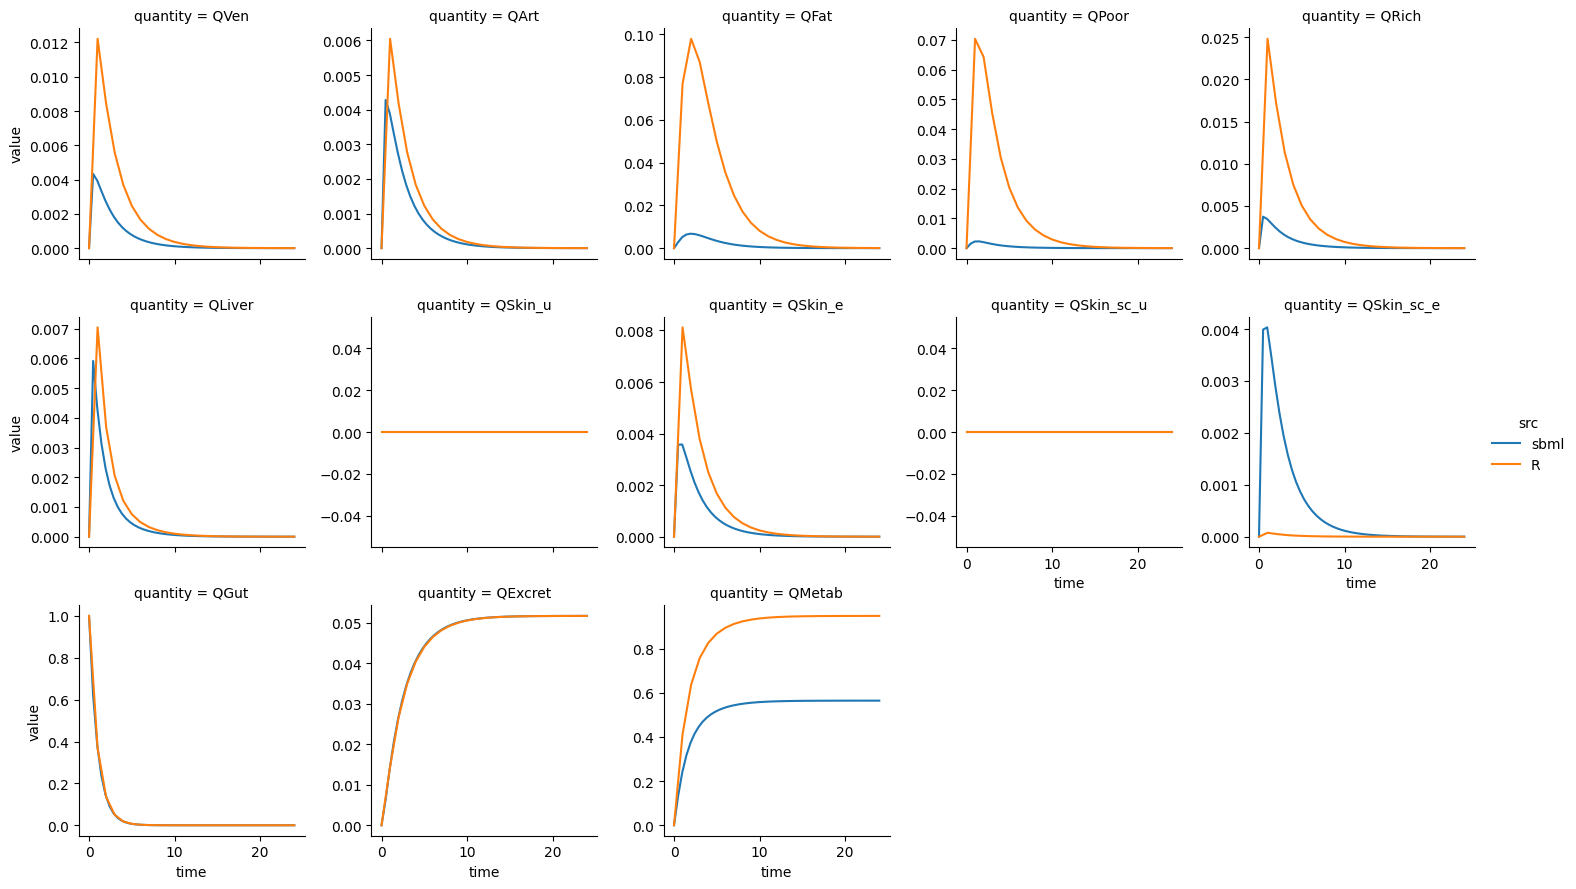

In [14]:
def compare(results):
    names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
    df = pd.DataFrame(results, columns=names).fillna(0)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['src'] = 'sbml'
    all_df = pd.concat((long_df, long_r))
    g = sns.FacetGrid(all_df, col='quantity', hue='src', col_wrap=5, sharey=False,
                     col_order=q_cols.values())
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()
    
r = te.loada(fn_ant)
r.QGut = 1
compare(r.simulate(0, 24))


# Compare parameter values

In [15]:
import csv
r = te.loada(fn_ant)

with open('../tmp/r_inputs_full.csv') as f:
    r_pars = {row[0] : float(row[1]) for row in csv.reader(f) if len(row[0]) > 0}

for par in r_pars:
    try:
        s = f'{par} - SBML: {r.getValue(par)} - R: {r_pars[par]}'
        if r.getValue(par) == r_pars[par]:
            print(f'MATCH - {s}')
        else:
            print(f'NO MATCH - {s}')
    except:
        continue

MATCH - BM - SBML: 70.0 - R: 70.0
MATCH - BSA - SBML: 190.0 - R: 190.0
MATCH - scVFat - SBML: 0.209 - R: 0.209
MATCH - scVRich - SBML: 0.105 - R: 0.105
MATCH - scVLiver - SBML: 0.024 - R: 0.024
MATCH - scVBlood - SBML: 0.068 - R: 0.068
MATCH - Height_sc - SBML: 0.0001 - R: 0.0001
MATCH - Height_vs - SBML: 0.0122 - R: 0.0122
MATCH - scFBlood - SBML: 4.8 - R: 4.8
MATCH - scFFat - SBML: 0.085 - R: 0.085
MATCH - scFPoor - SBML: 0.12 - R: 0.12
MATCH - scFLiver - SBML: 0.27 - R: 0.27
MATCH - scFSkin - SBML: 0.05 - R: 0.05
MATCH - Falv - SBML: 2220.0 - R: 2220.0
MATCH - PCAir - SBML: 1e+99 - R: 1e+99
MATCH - Kp_sc_vs - SBML: 0.01 - R: 0.01
MATCH - Ke - SBML: 7.5 - R: 7.5
MATCH - Michaelis - SBML: 0.0 - R: 0.0
MATCH - Vmax - SBML: 0.0 - R: 0.0
MATCH - Km - SBML: 0.0 - R: 0.0
MATCH - CLH - SBML: 132.0 - R: 132.0
MATCH - fub - SBML: 0.51 - R: 0.51
MATCH - Frac - SBML: 1.0 - R: 1.0
MATCH - kGut - SBML: 1.0 - R: 1.0
MATCH - Cinh - SBML: 0.0 - R: 0.0
MATCH - Tinh - SBML: 0.0 - R: 0.0
MATCH - OralDo

All mismatches due to rounding differences.

# Check ODEs

In [9]:
import libsbml as ls

r = te.loada(fn_ant)
r.exportToSBML(fn_sbml)

document = ls.readSBML(fn_sbml)
model = document.getModel()

# Get the list of species IDs
species_ids = [species.getId() for species in model.getListOfSpecies()]

# Initialize dictionaries to store the differential equations and reaction rates
differential_equations = {}
reaction_rates = {}

# Iterate over the reactions in the model
for i in range(model.getNumReactions()):
    reaction = model.getReaction(i)
    
    # Get the kinetic law associated with the reaction
    kinetic_law = reaction.getKineticLaw()
    if kinetic_law is None:
        continue
    
    # Get the reaction rate formula
    rate_formula = ls.formulaToString(kinetic_law.getMath())
    
    # Iterate over the reactants and products of the reaction
    for j in range(reaction.getNumReactants()):
        reactant = reaction.getReactant(j)
        species_id = reactant.getSpecies()
        
        # Add the reaction rate to the dictionary
        if species_id in reaction_rates:
            reaction_rates[species_id].append(f"- {rate_formula}")
        else:
            reaction_rates[species_id] = [f"- {rate_formula}"]
    
    for j in range(reaction.getNumProducts()):
        product = reaction.getProduct(j)
        species_id = product.getSpecies()
        
        # Add the negative reaction rate to the dictionary
        if species_id in reaction_rates:
            reaction_rates[species_id].append(rate_formula)
        else:
            reaction_rates[species_id] = [rate_formula]

# Construct the differential equations for each species
for species_id in species_ids:
    if species_id in reaction_rates:
        new_line = '\n'
        pref = f'{new_line}{" " * (len(species_id) + 8)}'
        equation = f"d{species_id}/dt = {f'{pref} + '.join(reaction_rates[species_id])}"
        differential_equations[species_id] = equation.replace("+ -", "-")

# Print the differential equations for each species
for species_id, equation in differential_equations.items():
    print(equation)

dQFat/dt = FFat * (QArt / Art)
             - FFat * (QFat / Fat) / PCFat
dQRich/dt = FRich * (QArt / Art)
              - FRich * (QRich / Rich) / PCRich
dQPoor/dt = FPoor * (QArt / Art)
              - FPoor * (QPoor / pp) / PCPoor
dQLiver/dt = FLiver * (QArt / Art)
               - FLiver * (QLiver / liver) / PCLiver
               + kGut * QGut
               - fub * CLH * (QLiver / liver) / PCLiver
dQMetab/dt = fub * CLH * (QLiver / liver) / PCLiver
dQGut/dt = - kGut * QGut
dQSkin_u/dt = FSkin_u * (QArt / Art)
                - FSkin_u * (QSkin_u / su) / PCSkin
                - Kp_sc_vs * BSA * (1 - fSA_exposed) * (QSkin_u / su) / PCSkin_sc
                + Kp_sc_vs * BSA * (1 - fSA_exposed) * (QSkin_sc_u / scu)
dQSkin_e/dt = FSkin_e * (QArt / Art)
                - FSkin_e * (QSkin_e / se) / PCSkin
                - Kp_sc_vs * BSA * fSA_exposed * (QSkin_e / se) / PCSkin_sc
                + Kp_sc_vs * BSA * fSA_exposed * (QSkin_sc_e / sce)
dQSkin_sc_u/dt = Kp_sc_vs * BSA * (1 -

At first glance, `d[Art]/dt` does not match with the model defintion (from Tebby 2020 or the c source), which states:

```
  dQArt/dt = -Falv * CArt / PCAir + FBlood * (CVen - CArt) - QExcret
```

instead of 

```
dQArt/dt = - FFat * (QArt / Art)
             - FRich * (QArt / Art)
             - FPoor * (QArt / Art)
             - FLiver * (QArt / Art)
             - FSkin_u * (QArt / Art)
             - FSkin_e * (QArt / Art)
             + FBlood * (QVen / Ven)
             - Falv * (QArt / Art) / PCAir
             - Ke * fub * (QArt)
```

However: `FFat + FRich + FPoor + FLiver + FSkin_u +  is equal to `Fblood`, so

```
- FFat * (QArt / Art)
             - FRich * (QArt / Art)
             - FPoor * (QArt / Art)
             - FLiver * (QArt / Art)
             - FSkin_u * (QArt / Art)
             - FSkin_e * (QArt / Art)
```

is equal to `-FBlood * Cart`; so the equations actually match.